### 인공 신경망

In [1]:
import torch
from torchvision import datasets, transforms # datasets : 데이터셋 로더, transforms : 데이터 전처리
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# 데이터 전처리 정의: ToTensor()와 Normalize()
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 평균 0.5, 표준편차 0.5로 정규화
])

# transforms.ToTensor: 이미지를 텐서로 변환(픽셀 값이 [0, 1] 범위로 정규화됨).
# transforms.Normalize((0.5,), (0.5,)): 평균 0.5, 표준편차 0.5로 데이터를 정규화

In [3]:
# 패션 MNIST 데이터 로드
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform) # train=True : 훈련용 데이터 가져옴
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform) # download=True : 데이터셋이 없을 경우 다운로드

In [4]:
# 훈련 데이터와 검증 데이터 분리
train_size = int(0.8 * len(train_dataset))  # train 데이터의 80%
val_size = len(train_dataset) - train_size  # train 데이터의 20%
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size]) # 훈련과 검증으로 분할

In [5]:
# 데이터로더 생성 : 데이터셋을 배치 단위로 반복(iterate)할 수 있도록 제공하는 유틸리티
# DataLoader는 Python의 **이터레이터(Iterator)**처럼 동작
# DataLoader는 매번 **배치(batch)**를 반환하며, 모든 데이터를 처리할 때까지 이를 반복
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# batch_size=64: 한 번에 64개의 데이터를 가져옴
# shuffle=True: 훈련 데이터는 섞어서 불러옵니다 (훈련 효율을 위해 필요).
# shuffle=False : 검증 및 테스트 데이터는 순차적으로 불러옴(상관 없음)

In [6]:
# 데이터 확인
print(f"Train Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(val_dataset)} samples")
print(f"Test Dataset: {len(test_dataset)} samples")

Train Dataset: 48000 samples
Validation Dataset: 12000 samples
Test Dataset: 10000 samples


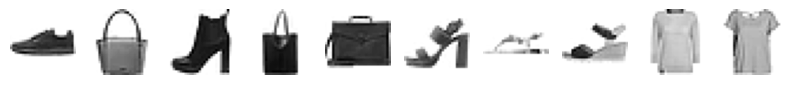

In [7]:
# 데이터 시각화
fig, axs = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    axs[i].imshow(train_dataset[i][0].squeeze().numpy(), cmap='gray_r')
    axs[i].axis('off')
plt.show()

#### 신경망 모델 정의

In [8]:
# 신경망 구성
class FashionClassifier(nn.Module):
    def __init__(self):
        super(FashionClassifier, self).__init__()
        self.fc = nn.Linear(28 * 28, 10)  # 28x28 이미지를 펼쳐 10개의 클래스로 분류
        # self.fc : 모든 입력노드가 모든 출력 노드와 연결된 구조(fully connected)

    def forward(self, x):
        x = x.reshape(-1, 28 * 28)  # 1D 벡터로 펼침
        x = self.fc(x)
        x = torch.softmax(x, dim = 1) # 소프트맥스 활성화 함수
        return x 
    
# nn.Linear: Fully Connected Layer를 생성합니다.
# 입력 크기: 28 * 28 (평탄화된 이미지).
# 출력 크기: 10 (패션 아이템 클래스 10개).
# torch.softmax: 출력값을 확률로 변환합니다.

In [9]:
model = FashionClassifier()
print(model)

# 모델 요약 (파라미터 수 확인)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params}")

FashionClassifier(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)
Total Parameters: 7850


#### 학습 및 평가

In [10]:
# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()  # 다중 클래스 크로스엔트로피 손실 함수
optimizer = optim.SGD(model.parameters(), lr=0.1)  # SGD 옵티마이저(확률적 경사하강법, 학습률 0.1)

In [11]:
# 학습 루프
epochs = 10
for epoch in range(epochs):
    model.train() # 훈련 모드 활성화: model.train()으로 모델을 훈련 모드로 설정.
    total_loss = 0 # total_loss: 각 에포크의 손실 값을 누적하기 위한 변수.
    correct = 0 # correct: 모델이 올바르게 예측한 샘플 개수를 누적하기 위한 변수.
    
    for images, labels in train_loader: # 훈련 데이터가 배치 단위로 반환
        # Forward pass
        outputs = model(images) # 입력 데이터(images)를 모델에 전달하여 출력값(outputs)을 계산
        loss = criterion(outputs, labels) # 예측값(outputs)과 실제 레이블(labels) 간의 손실 값을 계산

        # Backward pass
        optimizer.zero_grad() # 기울기를 초기화. 기울기(gradient)는 누적되는 특성이 있으므로, 매 배치마다 초기화가 필요
        loss.backward() # 손실 값(loss)을 기준으로 기울기를 계산, 역전파 수행
        optimizer.step() # 계산된 기울기를 사용해 모델의 가중치를 업데이트

        total_loss += loss.item() # 손실값 누적
        _, predicted = torch.max(outputs, 1) # 가장 높은 확률의 클래스의 인덱스 반환
        correct += (predicted == labels).sum().item() # 맞춘 샘플 개수를 계산.

    accuracy = correct / len(train_loader.dataset) # accuracy = correct / len(train_loader.dataset)로 정확도 계산.
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/10, Loss: 1308.7267, Accuracy: 0.7489
Epoch 2/10, Loss: 1247.6741, Accuracy: 0.8192
Epoch 3/10, Loss: 1236.5491, Accuracy: 0.8304
Epoch 4/10, Loss: 1230.1460, Accuracy: 0.8377
Epoch 5/10, Loss: 1225.8482, Accuracy: 0.8419
Epoch 6/10, Loss: 1222.6735, Accuracy: 0.8460
Epoch 7/10, Loss: 1220.2815, Accuracy: 0.8482
Epoch 8/10, Loss: 1218.1520, Accuracy: 0.8502
Epoch 9/10, Loss: 1216.4523, Accuracy: 0.8521
Epoch 10/10, Loss: 1214.6839, Accuracy: 0.8538


In [12]:
# 검증 데이터 평가
model.eval() # model.eval(): 평가 모드로 설정 (Dropout 등 비활성화).

val_correct = 0
with torch.no_grad(): # torch.no_grad(): 평가 중에는 기울기를 계산하지 않음(메모리 절약 및 속도 향상).
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_correct += (predicted == labels).sum().item()

In [13]:
val_accuracy = val_correct / len(val_loader.dataset) # 확도 계산: 검증 데이터에 대해 예측값과 실제값을 비교하여 정확도(val_accuracy)를 계산.
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.8561


### 심층 신경망

In [14]:
# 데이터 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [15]:
# Fashion MNIST 데이터셋 로드
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [16]:
# DataLoader 설정
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [17]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

In [18]:
from sklearn.model_selection import train_test_split

# Train/Validation Split
train_data, val_data = random_split(train_dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=42, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=42, shuffle=False)

In [19]:
# 신경망 정의
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(28 * 28, 100)
        self.relu = nn.ReLU()
        self.output = nn.Linear(100,10)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x) :
        x = self.flatten(x)
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x
    
# 모델 초기화
model = FashionMNISTModel()

In [20]:
# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.1)

In [21]:
# 모델 학습
epochs = 5
for epoch in range(epochs) :
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

Epoch 1, Loss: 0.538250228668761
Epoch 2, Loss: 0.40270882153969945
Epoch 3, Loss: 0.36192477811274565
Epoch 4, Loss: 0.3373019622992447
Epoch 5, Loss: 0.3183068980577737


In [22]:
# 검증
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Validation Accuracy: 87.72%


In [23]:
# 테스트
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 86.63%
